# DSCI100-32: Star Classification ⭐

## Introduction:

Star classification is an emerging field of research used to better understand the galaxies which surround us. Determining star types is vital in the research of extraterrestrial life, understanding stellar evolution, and predicting the future behaviour of our own sun. 
Our group will be working on the Star Dataset for Stellar Classification dataset from Kaggle. In the field of astronomy, star classification is based on a number of spectral characteristics, including apparent and absolute magnitude, spectral type, and color index.

We will use these predictors to calibrate whether we can correctly predict the chemical composition (spectral class) of an unknown star using the factors and information provided through the dataset.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)
install.packages('kknn')
#essential modules that are required in order to run most of our data analysis and given to us throughout DSCI100

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
colname = c("Vmag","distance","error_distance","color_index","spectral_type","Amag","Class")
stars <- read_csv("stars.csv", col_names = colname, skip = 1)
#Rewriting column names to more readable usages for overall data manipulation
stars

Rows: 3642 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): spectral_type
dbl (6): Vmag, distance, error_distance, color_index, Amag, Class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K5III,16.67835,0
8.70,2.31,1.29,-0.045,B1II,15.51806,0
5.77,5.50,1.03,0.855,G5III,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M0/M1IIICNp,13.02908,0
7.94,4.94,2.90,0.210,A5V,16.40864,1
8.81,1.87,1.23,1.176,K1/K2III,15.16921,0


In [3]:
stars <- stars |>
    mutate(spectral_type = case_when(grepl("K",spectral_type) ~ "K",
                                grepl("B",spectral_type) ~ "B", 
                                grepl("G",spectral_type) ~ "G", 
                                grepl("M",spectral_type) ~ "M", 
                                grepl("A",spectral_type) ~ "A",
                                grepl("F",spectral_type) ~ "F",
                                grepl("O",spectral_type) ~ "O",
                                grepl("C",spectral_type) ~ "C")) |>
    mutate(spectral_type = as_factor(spectral_type))
stars

Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K,16.67835,0
8.70,2.31,1.29,-0.045,B,15.51806,0
5.77,5.50,1.03,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M,13.02908,0
7.94,4.94,2.90,0.210,A,16.40864,1
8.81,1.87,1.23,1.176,K,15.16921,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


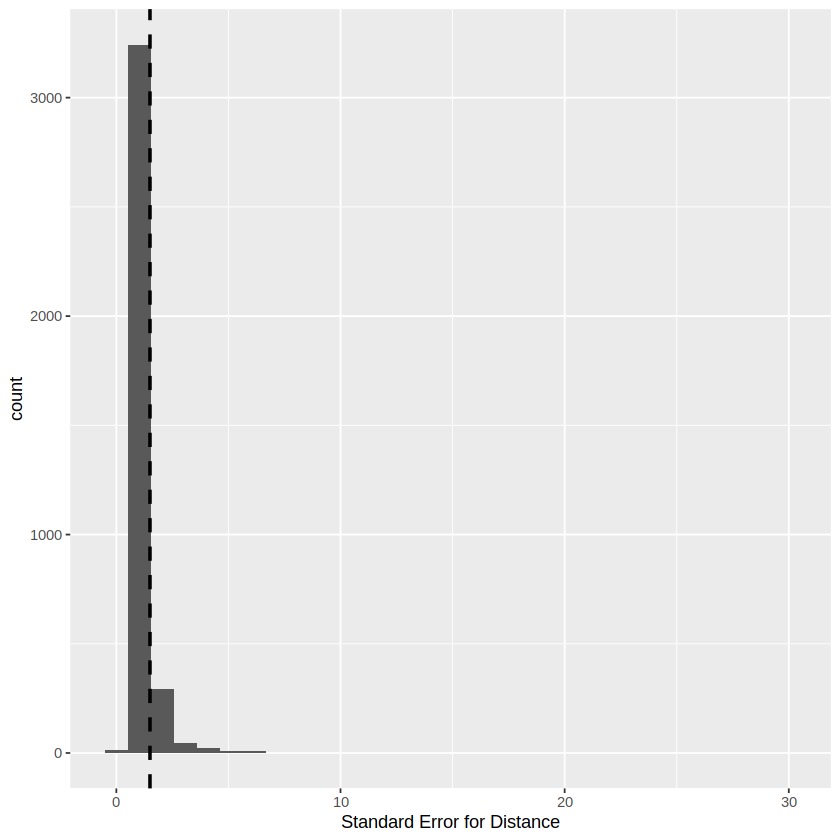

In [4]:
error_remove_plot <- stars |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram() +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1) +
    xlab("Standard Error for Distance")


error_remove_plot
# this plot shows the number of error values for the distance. The values left of the vertical line 
# will be kept and the values to the right will be discarded.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


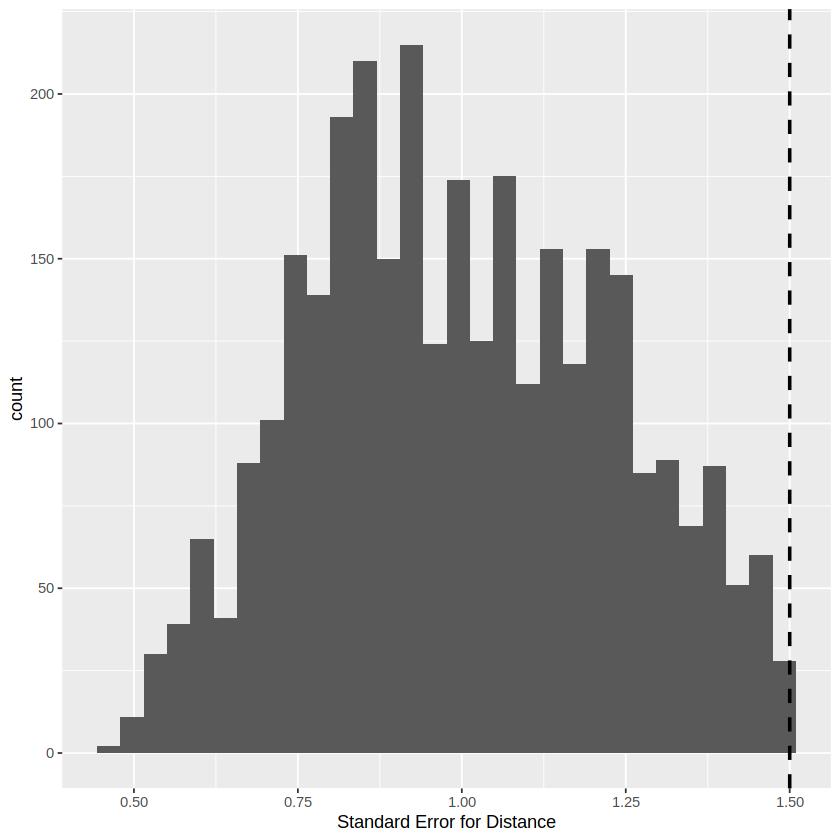

In [5]:
final_error_plot <- stars |>
    filter(error_distance < 1.50) |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram() +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1) +
    xlab("Standard Error for Distance")

final_error_plot

The dataset will be adjusted according to the information found above 
After the error distance is used to remove data points, the column has no further use.

In [6]:
stars <- stars |>
    filter(error_distance < 1.50)|>
    select( Vmag, distance, color_index, spectral_type, Amag ,Class)

stars

Vmag,distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,1.318,K,16.67835,0
8.70,2.31,-0.045,B,15.51806,0
5.77,5.50,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,17.31410,1
6.11,2.42,1.664,M,13.02908,0
8.81,1.87,1.176,K,15.16921,0


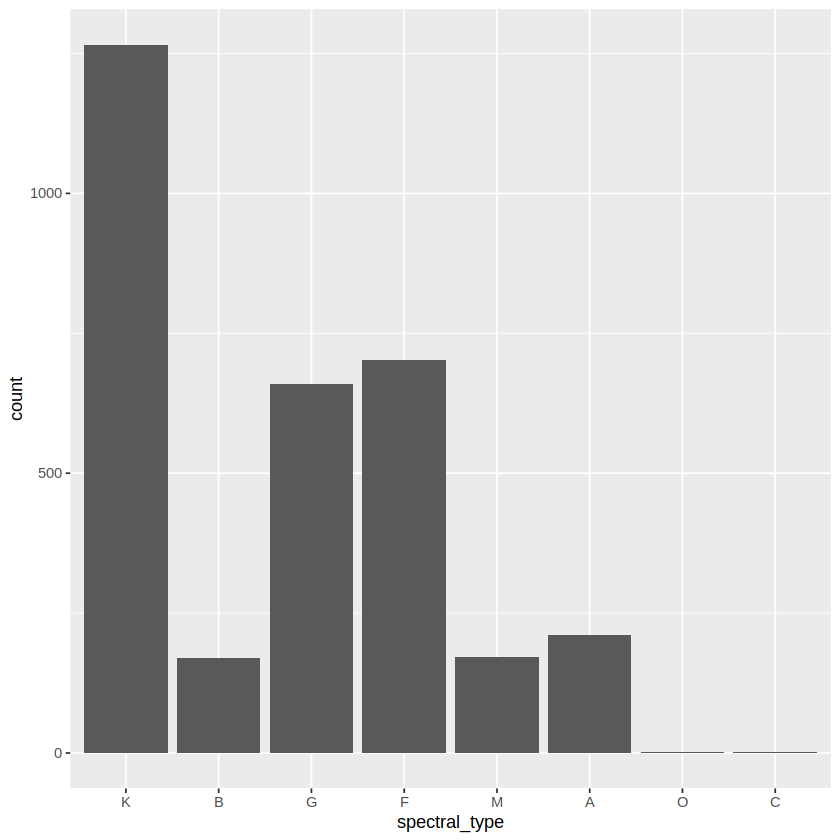

In [7]:
spectral_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() 

spectral_plot

As shown in the Figure above, there are a very limited number of observations with the spectral type O and C. Due to this, these types will be removed. 

In [8]:
stars <- stars |>
    filter( spectral_type != "O", spectral_type != "C")

stars  

Vmag,distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,1.318,K,16.67835,0
8.70,2.31,-0.045,B,15.51806,0
5.77,5.50,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,17.31410,1
6.11,2.42,1.664,M,13.02908,0
8.81,1.87,1.176,K,15.16921,0


With this, our data set is tidy and ready to be used for our purposes.

In [9]:
stars <- select(stars, -Amag)

stars

Vmag,distance,color_index,spectral_type,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>
5.99,13.73,1.318,K,0
8.70,2.31,-0.045,B,0
5.77,5.50,0.855,G,0
⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,1
6.11,2.42,1.664,M,0
8.81,1.87,1.176,K,0


In [10]:
set.seed(2000)

star_split <- initial_split(stars, prop = 0.75, strata = spectral_type)
star_train <- training(star_split)
star_test <- testing(star_split) 

In [11]:
class_count <- star_train|>
    select(Class)|>
    group_by(Class)|>
    count(Class)

class_count

Class,n
<dbl>,<int>
0,1291
1,1093


This table represents the number of observations in our training data that are classified as Dwarfs (0) or Giants (1)

In [12]:
predictor_means <- star_train |>
    select(Vmag:color_index, Class) |>
    map_df(mean)

predictor_means

Vmag,distance,color_index,Class
<dbl>,<dbl>,<dbl>,<dbl>
7.923872,7.668507,0.8513721,0.4584732


This table shows the mean of all the predictors that can be used.

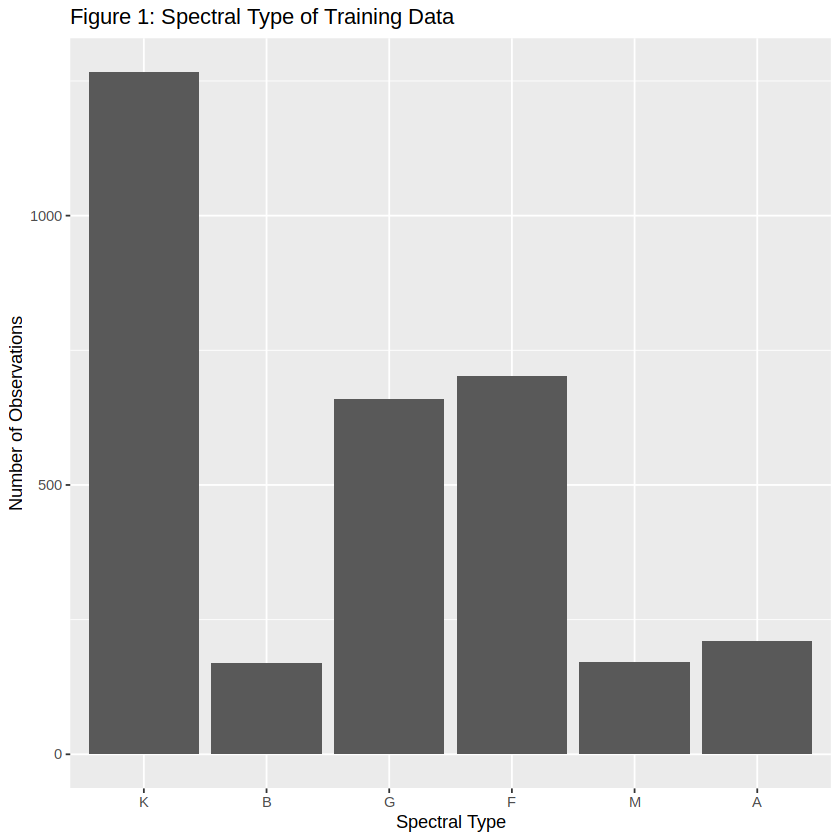

In [13]:
spectral_training_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() +
    labs(x = "Spectral Type", y = "Number of Observations") +
    ggtitle("Figure 1: Spectral Type of Training Data")
    

spectral_training_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


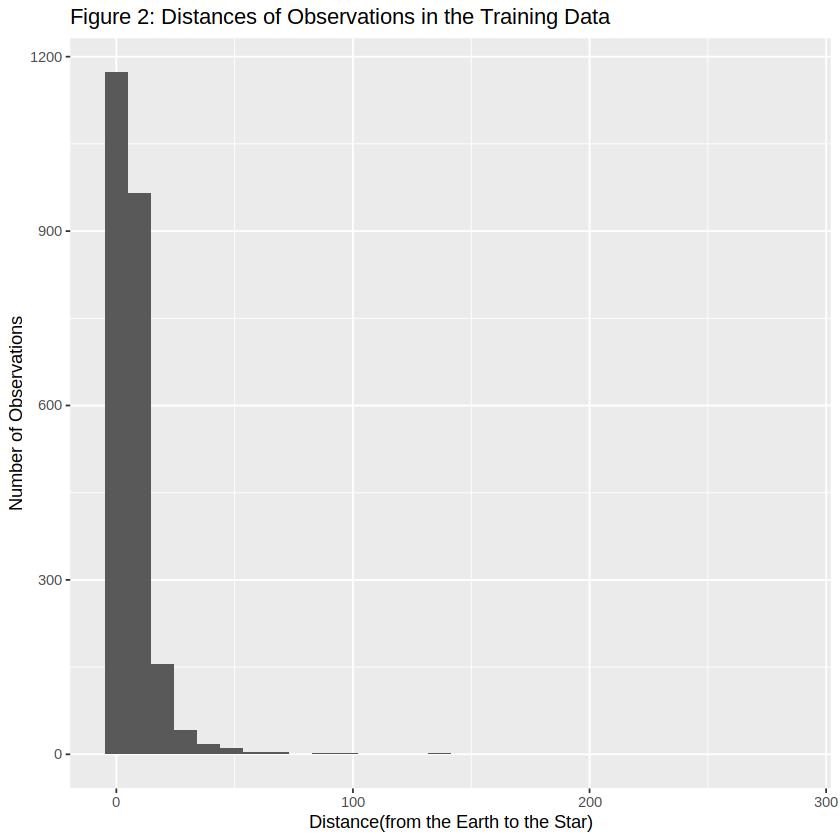

In [14]:
distance_training_plot <- star_train |>
    ggplot(aes(x = distance)) + 
    geom_histogram() +
    labs(x = "Distance(from the Earth to the Star)", y = "Number of Observations") +
    ggtitle("Figure 2: Distances of Observations in the Training Data")
    
distance_training_plot


In [15]:
spectral_training_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() +
    labs(x = "Spectral Type", y = "Number of Observations") +
    ggtitle("Figure 1: Spectral Type of Training Data")
    

## Methods:

In order to make our model more simple, we will be limiting the spectral type to the main classes(represented by the letters), disregarding the various sub-classes. Using the standard error for distance, we will remove any observations that have an extraneous amount of standard error. We will then use the visual apparent magnitude(lux), distance between the Star and Earth(parallax), spectral color index(B-V), and whether the star is a giant or dwarf, to predict spectral type of a new star. The absolute magnitude of the star was excluded in this set of predictors as it is not an observed value, but instead a value calculated from the apparent magnitude and distance. We will be using the knn algorithm to classify new observations. First, we will find the optimal number of neighbors that maximize the accuracy of our model. Then we will apply our findings to a new model. 


## Expected Outcomes and Significance:
With this completed model, the spectral type of a star can be determined so long as the apparent magnitude, distance from the Earth, color index, and whether the star is a giant or dwarf is known. Understanding the spectral type of a star is significant, as it provides a plethora of information about the star and even our universe as a whole. If we can derive the identity of a Spectral Class of a star, chemists could be able to examine the cosmic age of the star and approximate the period of time until which a star depletes its chemical reactants and either burns out or becomes a supernova.

In [16]:
stars

Vmag,distance,color_index,spectral_type,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>
5.99,13.73,1.318,K,0
8.70,2.31,-0.045,B,0
5.77,5.50,0.855,G,0
⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,1
6.11,2.42,1.664,M,0
8.81,1.87,1.176,K,0


! Fold1: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'O', 'C'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold2: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'O', 'C'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold3: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s)

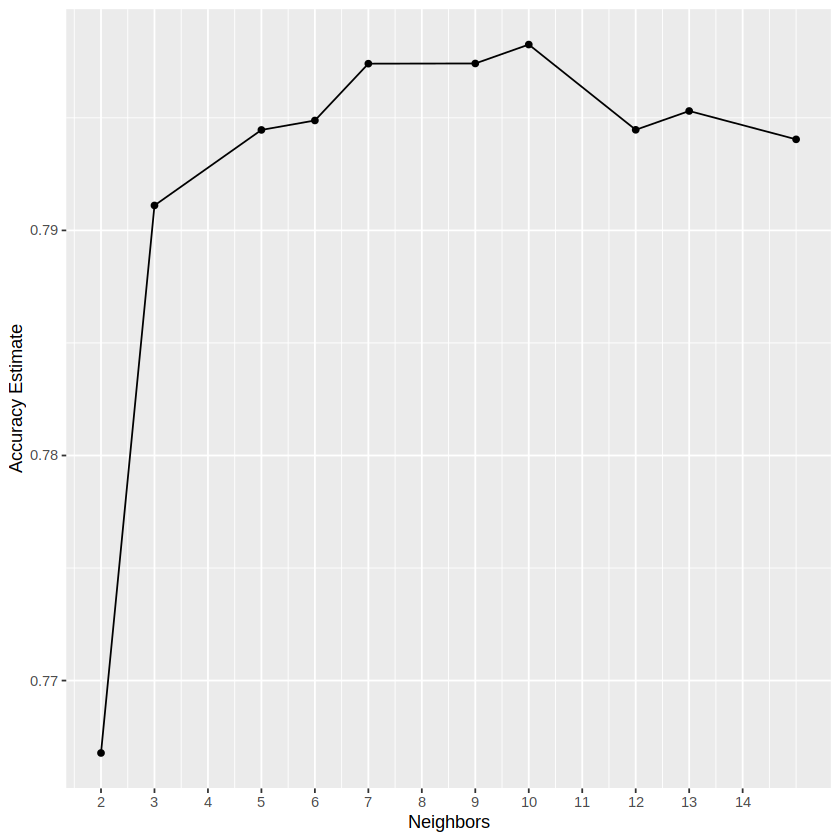

In [39]:
set.seed(1234)

star_recipe <- recipe(spectral_type ~ ., data = star_train)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


star_vfold <- vfold_cv(star_train, v = 5, strata = spectral_type)

star_tuning_fit <- workflow() |>
    add_recipe(star_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = star_vfold, grid = 10) |>
    collect_metrics()

accuracies <- star_tuning_fit |>
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1))

accuracy_versus_k

Judging from the plot above, it would be optimal to use 10 neighbors.

In [35]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("classification")

star_fit <- workflow() |>
       add_recipe(star_recipe) |>
       add_model(knn_spec) |>
       fit(data = star_train)
star_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2000839
Best kernel: rectangular
Best k: 10

In [36]:
star_test_prediction <- predict(star_fit , star_test) |>
       bind_cols(star_test)

star_test_prediction

.pred_class,Vmag,distance,color_index,spectral_type,Class
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
F,7.57,8.67,0.528,F,1
M,7.58,3.47,1.626,M,0
A,8.27,1.62,0.146,B,1
⋮,⋮,⋮,⋮,⋮,⋮
F,8.81,5.71,0.512,F,1
A,7.23,4.91,0.010,A,1
K,6.64,4.46,1.301,K,0


In [37]:
star_prediction_accuracy <- star_test_prediction |>
         metrics(truth = spectral_type, estimate = .pred_class)  
star_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7849057
kap,multiclass,0.7075684


As shown above, the accuracy estimate for the optimal workflow is 78.5%. As an example of the applications of the model, the predictors of the star Polaris were used with the model.

In [38]:
obs_polaris <- tibble(Vmag = 8.7, distance = 7.54, color_index = 0.42, Class = 1)


predict(star_fit, obs_polaris)

.pred_class
<fct>
F


The model predicted that Polaris would have a spectral type of F. Due o our pre-existing knowledge of Polaris, we can confirm that this is correct. (SITE POLARIS WIKAPEDIA)

## Discussion

Through our exploration of the information in our data set, we have been able to create a model that can predict the spectral type of a star with 87.4 percent accuracy. While this was what we aimed to achieve, the model does have some significant drawbacks. Our model is unable to correctly classify a star of type O or C. This is because our original data set lacked sufficient information on the two classes, and the classes were ultimately removed the the model entirely. 